## Software: `Pythia`


The outcome of the Matrix Elemebnt (ME) computation doesn't account for all the QCD effects. It only deals the with the hard scattering ignoring the QCD dynamics that may occur before and after the hard interaction. The participating quarks and gluons can radiate additional quarks and gluons leading to a cascade or shower of final states that populate the detector. This is where Pythia's parton shower comes into play. In a nutshell, Pythia takes the "skeleton" events from the ME calculation and "dresses" them with QCD. 

### Particle showers (PS) 

Pythia's parton shower captures the essence of perturbative QCD in the leading-logarithm approximation, evolving parton states probabilistically based on splitting functions derived from the theory. The PS bridges the gap between a hard scatter described by a ME and the non-perturbative hadronization process, providing a more complete and realistic picture of high-energy particle interactions in the SM and beyond.  

### Hadronization

After the parton shower, you have a collection of quarks and gluons. But we don't see individual quarks or gluons in our detectors; we see hadrons. The process of turning these quarks and gluons into hadrons (like protons, pions, kaons, etc.) is dubbed hadronization. Pythia typically uses pheonomenological models like e.g. the *Lund String Model* where quarks and gluons are assumed to be connected by "strings" of QCD fields, and when these strings stretch too far, they "snap", producing new quark-antiquark pairs that then ultimately form the observed hadrons.

### Decays

Besides QCD Showering and Hadrnozation, Pythia also handles the decays of the hadrons, and more importantly, of the $\tau$-lepton (Madgraph does not allow for tau decays in the hard process).

## 

## Pythia in practice

Pythia can be used for showering, hadnroization and particle decays from within MadGraph. After installation, Pythia can be activated after launching the process via 

    MG5_aMC> Pythia=ON

This produces the `pythia8_card.dat` file in the process card folder. This card can be modified beyond the following default settings if necessary.

    
    ! Pythia8 cmd card automatically generated by MadGraph5_aMC@NLO
    ! For more information on the use of the MG5aMC / Pythia8 interface, visit
    !    https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/LOPY8Merging
    !
    ! ==================
    ! General parameters 
    ! ==================
    
    Main:numberOfEvents      = -1
    HEPMCoutput:file         = auto
    
    ! --------------------------------------------------------------------
    ! Parameters relevant only when performing MLM merging, which can be
    ! turned on by setting ickkw to '1' in the run_card and chosing a 
    ! positive value for the parameter xqcut.
    ! For details, see section 'Jet Matching' on the left-hand menu of 
    !    http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html
    ! --------------------------------------------------------------------

    JetMatching:qCut         = -1.0
    JetMatching:doShowerKt   = off
    JetMatching:nJetMax      = -1
    
    ! --------------------------------------------------------------------
    ! Parameters relevant only when performing CKKW-L merging, which can
    ! be turned on by setting the parameter 'ptlund' *or* 'ktdurham' to
    ! a positive value. 
    ! For details, see section 'CKKW-L Merging' on the left-hand menu of 
    !    http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html
    ! --------------------------------------------------------------------

    Merging:TMS              = -1.0
    Merging:Process          = <set_by_user>
    Merging:nJetMax          = -1
    SysCalc:fullCutVariation = off
    
    ! ==========================
    ! User customized parameters 
    ! ==========================
    
    partonlevel:mpi = on   ! By default, Pythia8 generates multi-parton interaction events. 
    

Most of the card refers to jet matching and merging, which is not necesary in the exmaples we explore in here. OF intierest
is the end of the file where specific commands can be written. E.g. whether MPI are to be included, ISR/FSR, specific tau decay 
"Tunes". For the full list of commands see the Pythia8 manual.

### The `HepMC` file 

The output of the showering /hadronization process is typically stored in a very large event file in either `ROOT` or `HepMC` formats. We will use 
HepMC since these are easy to parse in python compared to `ROOT` 

Below we use the method `open_HepMC` to access the final state particles after hadronization. It works pretty much the same as `open_lhe()` by looping over events.

In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from BSMhighPT2023.utils import open_HepMC

def get_HepMC_events(path):
    events = []
    with open_HepMC(path=hepmc_file) as showered_events:
        for event in showered_events:
            events.append(event)
    return events


In [2]:
hepmc_file = 'RUNS/PROC_dimuon_SM/Events/run_01/tag_1_pythia8_events.hepmc'

events = get_HepMC_events(path=hepmc_file)

#...inspect first event:

print(events[0])
print('number of particles in event: ', len(events[0]))

INFO: reading hepmc file
[(2.51126535e+01,  -0.79975181,  1.18958976, 1.05660000e-01,  9.34292919e+00,  2.33099773e+01, -2.22943627e+01, 3.35811724e+01,   -13)
 (1.81200040e+01,   1.74010072, -0.80442323, 1.05660000e-01,  1.25667097e+01, -1.30542082e+01,  5.00330869e+01, 5.32133019e+01,    13)
 (1.58909708e+01,   0.95522942, -2.13867057, 6.74349576e-07, -8.54681803e+00, -1.33968225e+01,  1.75956187e+01, 2.37092545e+01,    22)
 (5.32210419e+00,   1.72588212, -0.81541036, 2.38418579e-07,  3.64867342e+00, -3.87452904e+00,  1.44746816e+01, 1.54221010e+01,    22)
 (3.10623074e+00,   0.10075178,  2.76921491, 1.39570000e-01, -2.89334485e+00,  1.13014379e+00,  3.13488029e-01, 3.12512783e+00,   211)
 (2.21481132e+00,   0.29116792,  3.04917028, 3.94247668e-08, -2.20535870e+00,  2.04406821e-01,  6.54032751e-01, 2.30936095e+00,    22)
 (2.05117122e+00,   0.66049196,  3.10038282, 4.93680000e-01, -2.04942977e+00,  8.45044964e-02,  1.45545704e+00, 2.56307989e+00,  -321)
 (1.89418716e+00,  -0.08843822

Events are lists of structured numpy arrays with rows corresponding to the particles. These have the following features:

In [3]:
events[0].dtype.names

('pt', 'eta', 'phi', 'M', 'px', 'py', 'pz', 'E', 'pid')

In [4]:
event_df = pd.DataFrame(events[0])  # event as a Pandas dataframe
event_df

,pt,eta,phi,M,px,py,pz,E,pid
0,25.112654,-0.799752,1.189590,1.056600e-01,9.342929,23.309977,-22.294363,33.581172,-13
1,18.120004,1.740101,-0.804423,1.056600e-01,12.566710,-13.054208,50.033087,53.213302,13
2,15.890971,0.955229,-2.138671,6.743496e-07,-8.546818,-13.396822,17.595619,23.709254,22
3,5.322104,1.725882,-0.815410,2.384186e-07,3.648673,-3.874529,14.474682,15.422101,22
4,3.106231,0.100752,2.769215,1.395700e-01,-2.893345,1.130144,0.313488,3.125128,211
...,...,...,...,...,...,...,...,...,...
84,0.040685,1.774318,-0.845095,0.000000e+00,0.027001,-0.030433,0.116493,0.123394,22
85,0.039523,-0.558507,1.865541,1.646361e-09,-0.011481,0.037818,-0.023239,0.045849,22
86,0.038928,5.021151,1.714447,5.960464e-08,-0.005573,0.038527,2.950367,2.950624,22
87,0.034584,-11.816810,0.518156,9.382700e-01,0.030044,0.017129,-2343.271128,2343.271316,2212


## A cute package for Particle Identification

We can get information about the particles in the events using `particle`

In [5]:
from particle import Particle 

# https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf

event_df['name'] = event_df['pid'].apply(Particle.from_pdgid) #event['pid'].apply(PDG)
event_df

,pt,eta,phi,M,px,py,pz,E,pid,name
0,25.112654,-0.799752,1.189590,1.056600e-01,9.342929,23.309977,-22.294363,33.581172,-13,mu+
1,18.120004,1.740101,-0.804423,1.056600e-01,12.566710,-13.054208,50.033087,53.213302,13,mu-
2,15.890971,0.955229,-2.138671,6.743496e-07,-8.546818,-13.396822,17.595619,23.709254,22,gamma
3,5.322104,1.725882,-0.815410,2.384186e-07,3.648673,-3.874529,14.474682,15.422101,22,gamma
4,3.106231,0.100752,2.769215,1.395700e-01,-2.893345,1.130144,0.313488,3.125128,211,pi+
...,...,...,...,...,...,...,...,...,...,...
84,0.040685,1.774318,-0.845095,0.000000e+00,0.027001,-0.030433,0.116493,0.123394,22,gamma
85,0.039523,-0.558507,1.865541,1.646361e-09,-0.011481,0.037818,-0.023239,0.045849,22,gamma
86,0.038928,5.021151,1.714447,5.960464e-08,-0.005573,0.038527,2.950367,2.950624,22,gamma
87,0.034584,-11.816810,0.518156,9.382700e-01,0.030044,0.017129,-2343.271128,2343.271316,2212,p


In [68]:
from particle import PDGID

photon = PDGID(22) 
print(photon.info())

proton = PDGID(2212) 
print(proton.info())

A              None
J              1.0
L              None
S              None
Z              None
abspid         22
charge         0.0
has_bottom     False
has_charm      False
has_down       False
has_fundamental_anti False
has_strange    False
has_top        False
has_up         False
is_Qball       False
is_Rhadron     False
is_SUSY        False
is_baryon      False
is_diquark     False
is_dyon        False
is_excited_quark_or_lepton False
is_gauge_boson_or_higgs True
is_generator_specific False
is_hadron      False
is_lepton      False
is_meson       False
is_nucleus     False
is_pentaquark  False
is_quark       False
is_sm_gauge_boson_or_higgs True
is_sm_lepton   False
is_sm_quark    False
is_special_particle False
is_technicolor False
is_valid       True
j_spin         3
l_spin         None
s_spin         None
three_charge   0

A              1
J              0.5
L              None
S              None
Z              1
abspid         2212
charge         1.0
has_bottom     False


In [67]:
from BSMhighPT2023.utils import PDG_Info

PDG_Info(2212)
# PDG_Info(211)
# PDG_Info(130)
# PDG_Info(2112)
# PDG_Info(2212)

pid,2212
name,p
mass (MeV),9.4e+02
width (MeV),0.0e+00
lifetime (s),inf
charge (e),1
quarks,uud


## Particle "Clouds"

Events at Hadron colliders are messy. Even if gthe hard process has clean final states

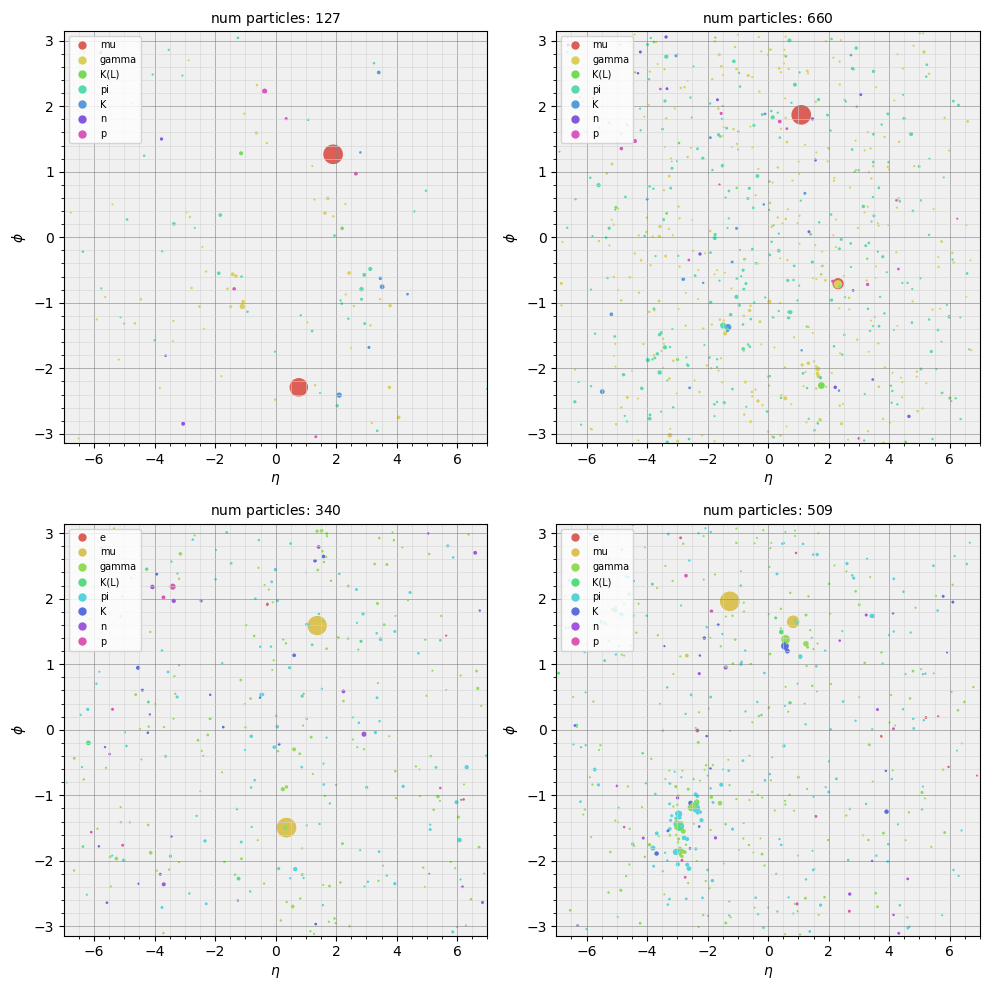

In [58]:
from BSMhighPT2023.plotting import event_display_grid, event_display

event_display_grid(events[4:8], nrows=2, ncols=2, point_sizes=(2,200), lw=0, figsize=(10,10), grid=True)
        

# Kinematic distributions

we can use list comprehension to access some of the simpler event distributions. For example:

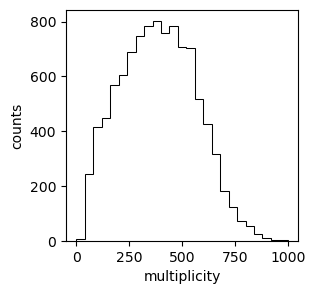

In [6]:
multiplicity = [len(ev) for ev in events]

# histogram for multiplicity

fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(multiplicity, bins=25, range=(0, 1000), histtype='step', color='black', lw=0.75)
ax.set_xlabel('multiplicity')
ax.set_ylabel('counts')
plt.show()

For more involved selections and cuts loop over event and use *boolean masks*:

In [7]:

muons = []

for event in events:
    
    mask = abs(event['pid']) == 13  # True / False if the particle is a muon or not
    mus = event[mask]             # apply mask to get muons only
    muons.append(mus)

pd.DataFrame(muons[0])

,pt,eta,phi,M,px,py,pz,E,pid
0,25.112654,-0.799752,1.189590,0.10566,9.342929,23.309977,-22.294363,33.581172,-13
1,18.120004,1.740101,-0.804423,0.10566,12.566710,-13.054208,50.033087,53.213302,13


In [4]:
def delta_phi(phi1, phi2):
    """get the correct delta phi between [-pi, pi]] for both numbers and arrays."""
    dphi = np.abs(phi1 - phi2)
    return np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)

In [5]:

Delta_pt = []
Delta_eta = []
Delta_phi = []
Delta_R = []
inv_mass= []

for event in events:

    mask = abs(event['pid']) == 13  # True / False if the particle is a muon or not
    muons = event[mask]             # apply mask to get muons only

    #...select diumons

    if len(muons)>=2:
        
        mu1 = muons[0]  # leading muon
        mu2 = muons[1]  # subleading muon

        dphi = delta_phi(mu1['phi'], mu2['phi'])
        dr = np.sqrt((mu1['eta'] - mu2['eta'])**2 + dphi**2)

        #... invariant mass: add the four-momenta

        dimuon =  np.zeros(mu1.shape, dtype=mu1.dtype)   # new empty array for the dimuon system

        for x in ['px', 'py', 'pz', 'E']:
            dimuon[x] = mu1[x] + mu2[x]  

        m = np.sqrt(dimuon['E']**2 - dimuon['px']**2 - dimuon['py']**2 - dimuon['pz']**2)

        

        #...store:

        Delta_pt.append(mu1['pt'] - mu2['pt'])
        Delta_eta.append(mu1['eta'] - mu2['eta'])
        Delta_phi.append(dphi)
        Delta_R.append(dr)
        inv_mass.append(m)



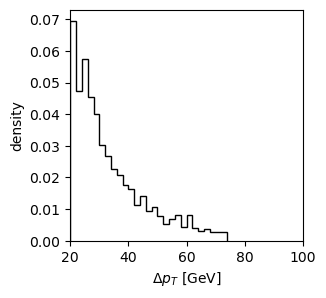

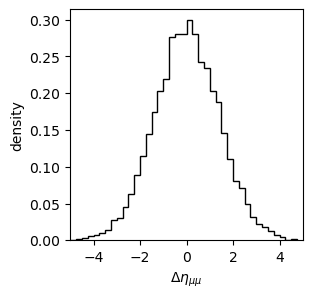

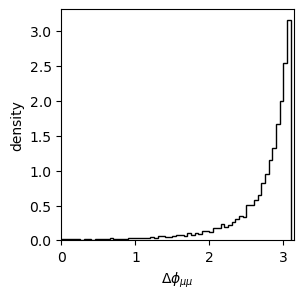

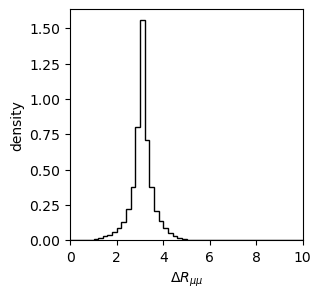

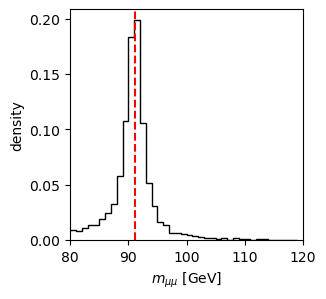

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(Delta_pt, bins=np.arange(20,75, 2), histtype='step', color='k', density=True)
ax.set_xlabel(r'$\Delta p_T$ [GeV]')
ax.set_ylabel('density')
ax.set_xlim(20,100)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(Delta_eta, bins=np.arange(-5,5, 0.25), histtype='step', color='k',  density=True)
ax.set_xlabel(r'$\Delta\eta_{\mu\mu}$')
ax.set_ylabel('density')
ax.set_xlim(-5,5)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(Delta_phi, bins=np.arange(0, np.pi, 0.05), histtype='step', color='k',  density=True)
ax.set_xlabel(r'$\Delta\phi_{\mu\mu}$')
ax.set_ylabel('density')
ax.set_xlim(0, np.pi)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(Delta_R, bins=np.arange(0, 12, 0.2), histtype='step', color='k', density=True)
ax.set_xlabel(r'$\Delta R_{\mu\mu}$')
ax.set_ylabel('density')
ax.set_xlim(0,10)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(inv_mass, bins=np.arange(70, 120, 1), histtype='step', color='k',  density=True)
ax.axvline(x=91.1876, color='red', linestyle='--', label='Z boson mass')
ax.set_xlabel(r'$m_{\mu\mu}$ [GeV]')
ax.set_ylabel('density')
ax.set_xlim(80,120)
plt.show()